## __Graphical Representation of Lake Erie Algal Blooms__

_TLDR:_ Predictive mechanism for algae blooms in the Western Basin of Lake Erie using buoy data.

In [452]:
# ----- Libraries -----
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime, timedelta
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from collections import defaultdict
from shapely.geometry import box
from shapely.geometry import Polygon
from shapely.ops import unary_union
import shapely as sv
from shapely.ops import polygonize
from shapely import points, covers
from PIL import Image, ImageDraw

Firstly, I unpacked the dataset only for the specific data that I planned to manipulate for the project. The dataset is fairly large, so doing so avoided confusion and leads to more succinct code. Unpacking to tuples makes the data frame much easier to manipulate further in the code.

I chose to study temperature, turbidity, and direct cyanobacterial presence, as those factors contribute the most to the aglal blooms. The simplicity of this model warrants focus only on such, as it is nearly impossible to be exhaustive of the factors contributing to algal blooms.

In [453]:
# ----- Unpack to Tuples -----
cols_use = ["Date_Dec", "Site", "Lat_deg", "Long_deg", "Temp_C", "Turbidity_NTU", "Extracted_CHLa_ugL-1"]
df = pd.read_csv("2025_WLE_Weekly_Datashare_CSV.csv", usecols=cols_use)

date = df["Date_Dec"]
site = df["Site"]
latitude = df["Lat_deg"].astype(float)
longitude = df["Long_deg"].astype(float)
temp = df["Temp_C"]
turbidity = df["Turbidity_NTU"]
chlorophyll = df["Extracted_CHLa_ugL-1"]

In [454]:
# ----- Map Appropriate Dictionaries -----
def avg_coords(indiv_site):
    '''
    Calculate the average location in latitude and longitude for
    each of the buoys in the dataset. (They move due to turbidity.any)
    '''
    lat_sum = 0
    long_sum = 0
    valid_site = 0
    for s, lat, long in zip(site, latitude, longitude):
        lat = float(lat)
        # to eliminate empty cells in the data frame
        if not math.isnan(lat) and not math.isnan(long) and s == indiv_site:
            lat_sum += lat
            valid_site += 1
            long_sum += long

    lat_avg = lat_sum / valid_site
    long_avg = long_sum / valid_site
    return lat_avg, long_avg

station_names = set(site)
site_to_coord = {}
for stat in station_names:
    site_to_coord[stat] = avg_coords(stat)

print(site_to_coord)

# to store each station's data in a different variable, needed to
# repetitively create dictionaries that append information for
# eaach respective date

we2_data = defaultdict(list)
we4_data = defaultdict(list)
we6_data = defaultdict(list)
we8_data = defaultdict(list)
we9_data = defaultdict(list)
we12_data = defaultdict(list)
we13_data = defaultdict(list)
we16_data = defaultdict(list)

for s, d, t, tb, c in zip(site, date, temp, turbidity, chlorophyll):
    if s == 'WE2':
        we2_data[d].append((t, tb, c))
    if s == 'WE4':
        we4_data[d].append((t, tb, c))
    if s == 'WE6':
        we6_data[d].append((t, tb, c))
    if s == 'WE8':
        we8_data[d].append((t, tb, c))
    if s == 'WE9':
        we9_data[d].append((t, tb, c))
    if s == 'WE12':
        we12_data[d].append((t, tb, c))
    if s == 'WE13':
        we13_data[d].append((t, tb, c))
    if s == 'WE16':
        we16_data[d].append((t, tb, c))

station_data = {'WE2': we2_data, 'WE4': we4_data, 'WE6': we6_data,
                'WE8': we8_data, 'WE9': we9_data, 'WE12': we12_data,
                'WE13': we13_data, 'WE16': we16_data,}

{'WE13': (41.743524982222226, -83.13666113), 'WE16': (41.65981860764707, -83.14357841117646), 'WE9': (41.717718940000005, -83.4229166518182), 'WE12': (41.70323649238095, -83.25394284095239), 'WE4': (41.826567484499996, -83.1953324825), 'WE6': (41.705815908181826, -83.38595303045453), 'WE2': (41.76156969727273, -83.33045378772727), 'WE8': (41.834032396666665, -83.35980922238096)}


Secondly, I created two kinds of dictionaries: one to map each site to its respective coordinates and a set of eight dictionaries that maps the date to its corresponding data for each station. Having these dictionaries will be important for creating an intital map to incidate the location of each of the stations, and to create projected maps for each set of data.

In [455]:
# ----- Shoreline -----
shoreline = gpd.read_file("us_medium_shoreline.shp")
shoreline = shoreline.set_crs(epsg = 4326)
west_bounds = (-83.8, 41.3, -82.4, 42.3)
western_box = box(*west_bounds)
western_poly = gpd.GeoDataFrame(geometry = [western_box], crs = "EPSG:4326")
western_shoreline = gpd.clip(shoreline, western_poly)

I uploaded the shoreline data using GeoPandas and converted it to a dataframe using a coordinate system based on latitude and longitude data. I designated bounds that focus on the western basin of Lake Erie, which is where algal blooms are (by far) the most severe and include the locations of every buoy in the dataset.

/var/folders/yd/m7njnczs3xdbw9j0w392qsdc0000gn/T/ipykernel_42747/4081747031.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  land_geom = western_shoreline.unary_union.buffer(0.001)


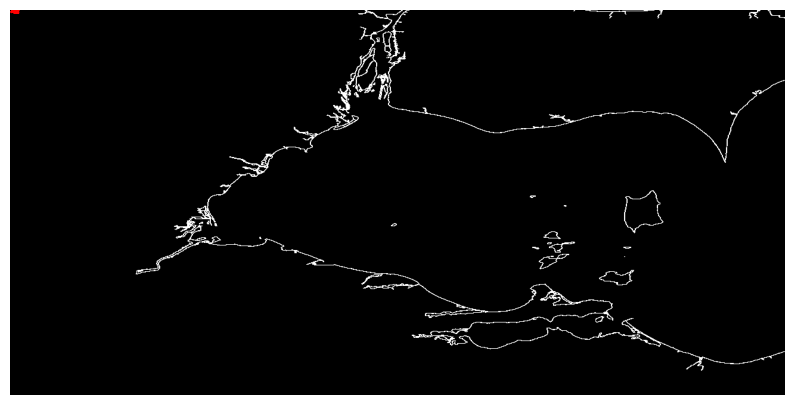

In [456]:
# ----- Create Image -----
nx, ny = 1300, 600
lon = np.linspace(west_bounds[0], west_bounds[2], nx)
lat = np.linspace(west_bounds[1], west_bounds[3], ny)
lon_grid, lat_grid = np.meshgrid(lon, lat)
land_geom = western_shoreline.unary_union.buffer(0.001)
pts = points(lon_grid, lat_grid)
land_mask = sv.covers(land_geom, pts)
img = np.ones((ny, nx, 3))      # shore borders are white
img[land_mask] = [0, 0, 0]      # everything else black

plt.figure(figsize=(10, 5))
ax=plt.gca()
plt.imshow(land_mask, extent=west_bounds, origin='lower', cmap='gray')
western_shoreline.plot(ax=ax, facecolor='none', edgecolor='red')

ax.set_aspect("auto")
plt.axis("off")
plt.show()

Created a NumPy array using the bounds of western Lake Erie that I created upon loading the shoreline data. I needed to add a buffer into the land geometry, as the shoreline is too fine for the number of pixels in the image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


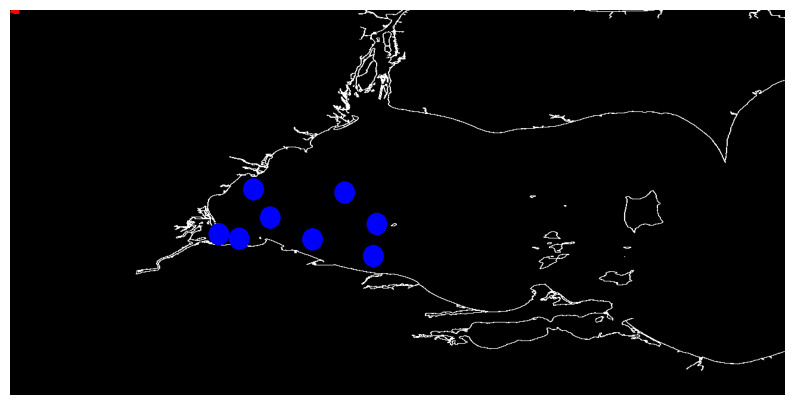

In [457]:
# ----- Plot Station Locations on Map -----
def station_color(site_dict, img_array):
    '''
    Mark the approximate location of each station using a circular range. 
    '''
    for s in site_dict:
        buoy_latitude, buoy_longitude = site_dict[s]
        
        # make sure that the latitiude is a valid float
        if (
            buoy_latitude is None
            or buoy_longitude is None
            or math.isnan(buoy_latitude)
            or math.isnan(buoy_longitude)
        ):
            continue
        
        dx = np.argmin(np.abs(lon_grid[0] - buoy_longitude))
        dy = np.argmin(np.abs(lat_grid[:, 0] - buoy_latitude))
        y, x = np.indices((ny, nx))
        
        station_rng = (x - dx)**2 + (y - dy)**2 <= 300
        img_array[station_rng] = (0, 0, 255)    # stations are blue circles

if __name__ == '__main__':
    # need to reset image and essentially create a copy to add the stations
    img = np.zeros((ny, nx, 3))     # images black
    img[land_mask] = [1, 1, 1]      # shoreline white
    station_color(site_to_coord, img)

    plt.figure(figsize=(10, 5))
    ax = plt.gca()

    ax.imshow(img, extent=west_bounds, origin='lower')
    western_shoreline.plot(ax=ax, facecolor='none', edgecolor='red')

    ax.set_aspect("auto")
    ax.axis("off")
    plt.show()

When plotting the location of the stations, we need to make sure that the latitudes an longitudes of each are a valid number (e.g. not NaN). After that, we need to mark the relative location of the buoys while finding there distance relative to the bounds of the image before creating a blue circle to denote the location of each. The image implements a nearly identical program to above, essentially creating a copy of the image and inserting the blue dots to mark the location of the map.

## __Developing the Models__

The model is evaluating turbidity and temperature and relating it to chlorophyll data. Chlorphyll, or the green pigment that givens plants their green color, is a very strong indicator of algal bloom severity given that algae is (somewhat obviously) a plant. Thus, by drawing relationships between turbditity, temperature, and chlorophyll, we can understand the potential consequence of global warming on algal bloom severity.

I chose to implement __ScikitLearn's Neural Networks__ library, which are computational models designed to recognize patters, process complex data, and continuously learn and improve over time without explicitly being programmed week to week. The process was implemented three times using the same algorithm for temperature, turbidity, and date. 

In [458]:
# ----- Cholorphyll vs. Temperature -----
# replace string placeholders with NaN
df = df.replace("NS", np.nan)

# convert columns explicitly to numeric
df["Temp_C"] = pd.to_numeric(df["Temp_C"], errors="coerce")
df["Extracted_CHLa_ugL-1"] = pd.to_numeric(
    df["Extracted_CHLa_ugL-1"], errors="coerce"
)

# drop rows with missing values
df = df.dropna(subset=["Temp_C", "Extracted_CHLa_ugL-1"])

X = df[["Temp_C"]].values
y = df["Extracted_CHLa_ugL-1"].values

temp_X_scaler = StandardScaler()
temp_y_scaler = StandardScaler()
X_scaled = temp_X_scaler.fit_transform(X)
y_scaled = temp_y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_scaled,
    test_size=0.20,
    random_state=42,
    shuffle=True
)
model_temp = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=42
)

model_temp.fit(X_train, y_train)

# predict (still scaled)
y_pred_scaled = model_temp.predict(X_test)

# convert predictions back to real units
y_pred = temp_y_scaler.inverse_transform(
    y_pred_scaled.reshape(-1, 1)
).ravel()

y_test_real = temp_y_scaler.inverse_transform(
    y_test.reshape(-1, 1)
).ravel()

mse = mean_squared_error(y_test_real, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 175.7025


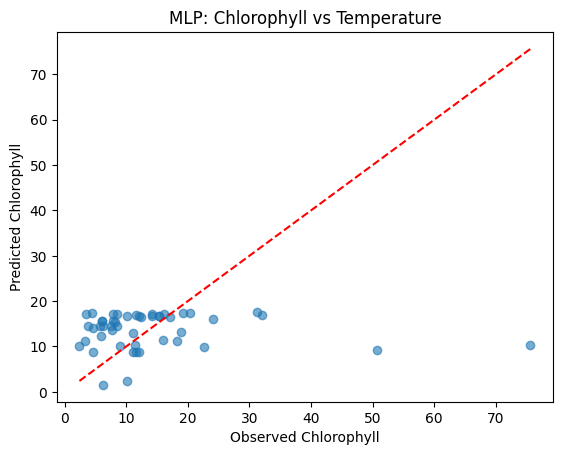

In [459]:
# ----- Plot Temperature vs. Chlorophyll -----
plt.scatter(y_test_real, y_pred, alpha=0.6)
plt.plot(
    [y_test_real.min(), y_test_real.max()],
    [y_test_real.min(), y_test_real.max()],
    "r--"
)
plt.xlabel("Observed Chlorophyll")
plt.ylabel("Predicted Chlorophyll")
plt.title("MLP: Chlorophyll vs Temperature")
plt.show()

In [460]:
# ----- Cholorphyll vs. Turbidity -----
# replace string placeholders with NaN
df = df.replace("NS", np.nan)

# convert columns explicitly to numeric
df["Turbidity_NTU"] = pd.to_numeric(df["Turbidity_NTU"], errors="coerce")
df["Extracted_CHLa_ugL-1"] = pd.to_numeric(
    df["Extracted_CHLa_ugL-1"], errors="coerce"
)

# drop rows with missing values
df = df.dropna(subset=["Turbidity_NTU", "Extracted_CHLa_ugL-1"])

X = df[["Turbidity_NTU"]].values
y = df["Extracted_CHLa_ugL-1"].values

turb_X_scaler = StandardScaler()
turb_y_scaler = StandardScaler()
X_scaled = turb_X_scaler.fit_transform(X)
y_scaled = turb_y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_scaled,
    test_size=0.20,
    random_state=42,
    shuffle=True
)
model_turb = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=42
)

model_turb.fit(X_train, y_train)

# predict (still scaled)
y_pred_scaled = model_turb.predict(X_test)

# convert predictions back to real units
y_pred = turb_y_scaler.inverse_transform(
    y_pred_scaled.reshape(-1, 1)
).ravel()

y_test_real = turb_y_scaler.inverse_transform(
    y_test.reshape(-1, 1)
).ravel()

mse = mean_squared_error(y_test_real, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 71.4746


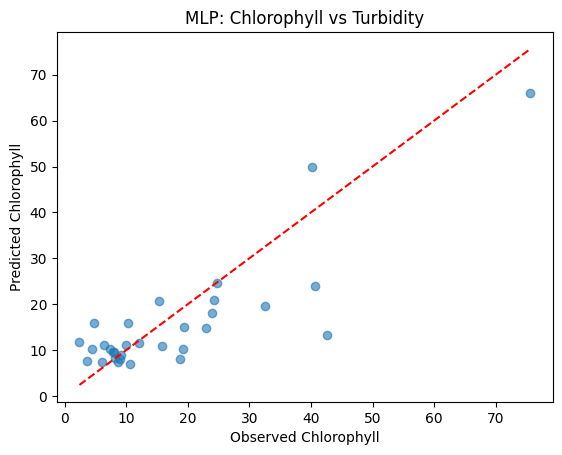

In [461]:
# ----- Plot Turbidity vs. Chlorophyll -----
plt.scatter(y_test_real, y_pred, alpha=0.6)
plt.plot(
    [y_test_real.min(), y_test_real.max()],
    [y_test_real.min(), y_test_real.max()],
    "r--"
)
plt.xlabel("Observed Chlorophyll")
plt.ylabel("Predicted Chlorophyll")
plt.title("MLP: Chlorophyll vs Turbidity")
plt.show()

In [462]:
# ----- Clean Data -----
df = df.replace("NS", np.nan)

df["Date_Dec"] = pd.to_numeric(df["Date_Dec"], errors="coerce")
df["Extracted_CHLa_ugL-1"] = pd.to_numeric(
    df["Extracted_CHLa_ugL-1"], errors="coerce"
)

df = df.dropna(subset=["Date_Dec", "Extracted_CHLa_ugL-1"])

# ----- Convert decimal year → day of year -----
date_model_year = df["Date_Dec"].astype(int)
date_model_frac = df["Date_Dec"] - date_model_year
df["date_model_doy"] = (date_model_frac * 365.25).astype(int)

# ----- Cyclical encoding (critical for seasonality) -----
df["date_model_doy_sin"] = np.sin(
    2 * np.pi * df["date_model_doy"] / 365
)
df["date_model_doy_cos"] = np.cos(
    2 * np.pi * df["date_model_doy"] / 365
)

# ----- Features / Target -----
X_date_model = df[["date_model_doy_sin", "date_model_doy_cos"]]
y_date_model = df["Extracted_CHLa_ugL-1"]

# ----- Train / Test Split -----
(
    X_date_model_train,
    X_date_model_test,
    y_date_model_train,
    y_date_model_test
) = train_test_split(
    X_date_model,
    y_date_model,
    test_size=0.2,
    random_state=42
)

# ----- DATE MODEL PIPELINE -----
date_model_pipeline = Pipeline([
    ("date_model_scaler", StandardScaler()),
    ("date_model_regressor", LinearRegression())
])

# ----- Train -----
date_model_pipeline.fit(
    X_date_model_train,
    y_date_model_train
)

# ----- Predict -----
y_date_model_pred = date_model_pipeline.predict(
    X_date_model_test
)

# ----- Evaluate -----
date_model_mse = mean_squared_error(
    y_date_model_test,
    y_date_model_pred
)

print(f"Date Model MSE: {date_model_mse:.4f}")

Date Model MSE: 248.1469


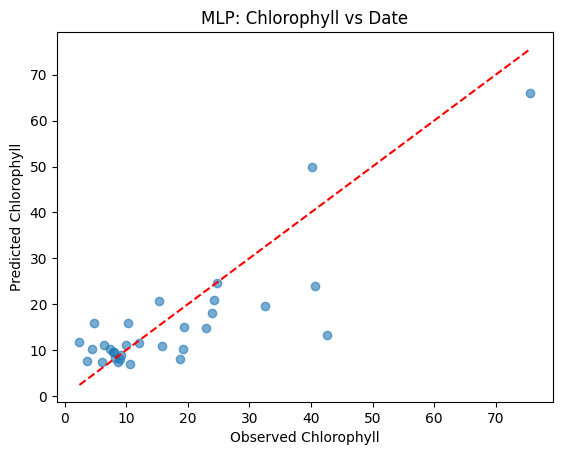

In [463]:
plt.scatter(y_test_real, y_pred, alpha=0.6)
plt.plot(
    [y_test_real.min(), y_test_real.max()],
    [y_test_real.min(), y_test_real.max()],
    "r--"
)
plt.xlabel("Observed Chlorophyll")
plt.ylabel("Predicted Chlorophyll")
plt.title("MLP: Chlorophyll vs Date")
plt.show()

I decided to work with the user-based portion of the project in another Python file, so I needed to save the models for export using Joblib. This also makes it easy for me to add onto the project as I become more knowledgable on machine learning.

In [464]:
# ----- Saving the Model-----
import joblib

filename1 = "alg_temp_model.sav"
joblib.dump(model_temp, filename1)
filename2 = "alg_turbidity_model.sav"
joblib.dump(model_turb, filename2)
filename3 = "alg_date_model.sav"
joblib.dump(date_model_pipeline, filename3)
joblib.dump(temp_X_scaler, "temp_X_scaler.sav")
joblib.dump(temp_y_scaler, "temp_y_scaler.sav")
joblib.dump(turb_X_scaler, "turb_X_scaler.sav")
joblib.dump(turb_y_scaler, "turb_y_scaler.sav")

['turb_y_scaler.sav']

__Application: Daily Predictions__

My goal is to use this data to make daily predictions about algae severity levels and projecting those severity levels onto the map I created by changing the color of the dots for each station and applying an outward gradient to the rest of the western basin. Thus, this data represents a daily _interpolation_, not a prediction or a measurement. We can use these interpolations to fill in the gaps and help to get a fuller picture of how aglae levels vary on a daily basis, not just a bi-weekly basis.

To do this, I need to convert the decimal dates to dates of the year (whole numbers from 1 to 365) and use the date model to predict the chlorophyll based on these numbers.

In [465]:
def date_model_predict_chl(mm, dd, year=2025):
    doy = pd.Timestamp(year=year, month=mm, day=dd).dayofyear

    X_new = pd.DataFrame({
        "date_model_doy_sin": [np.sin(2 * np.pi * doy / 365)],
        "date_model_doy_cos": [np.cos(2 * np.pi * doy / 365)]
    })

    return date_model_pipeline.predict(X_new)[0]

# daily ~interpolated~ chlorphyll-A estimates based on bi-weekly observations

Next, I need to predict the chlorphyll levels for _each station_ while converting back to the decimal date in order to predict the chlorophyll for each individual station. I chose to test August 15th for each respective station, but we can change the date by changing the month and day we pass through the predict_station_chl_by_date function.

In [ ]:
# ----- Split Data by Station -----
stations = df["Site"].unique()

station_dfs = {
    st: df[df["Site"] == st].copy()
    for st in stations
}

# compute station baselines
overall_mean_chl = df["Extracted_CHLa_ugL-1"].mean()

station_baseline_factor = {}

for st, sdf in station_dfs.items():
    station_mean = sdf["Extracted_CHLa_ugL-1"].mean()
    station_baseline_factor[st] = station_mean / overall_mean_chl

def predict_station_chl_by_date(mm, dd, year=2025):
    '''
    Predict chlorophyll by station for a given date.
    '''
    base_prediction = date_model_predict_chl(mm, dd, year)

    station_predictions = {}

    for st, factor in station_baseline_factor.items():
        station_predictions[st] = max(
            0,
            base_prediction * factor
        )

    return station_predictions

# test
aug15 = predict_station_chl_by_date(8, 15)  # month, day

In [474]:
# ----- Assign Severity Class -----
def assign_severity(chl_dict):
    sev = {}
    for st, chl in chl_dict.items():
        if chl >= 50:
            sev[st] = 2     # high
        elif chl >= 30:
            sev[st] = 1     # medium
        else:
            sev[st] = 0     # low
    return sev

stat_sev_aug15 = assign_severity(aug15)
print(stat_sev_aug15)

{'WE2': 0, 'WE4': 0, 'WE6': 0, 'WE8': 0, 'WE9': 1, 'WE12': 0, 'WE13': 0, 'WE16': 0}


After assigning the severity for each station and storing it in a dictionary, I then focused on __plotting the severity indices__. I decided to use green to indicate low chlorophyll levels, yellow to indicate moderate chlorophyll levels, and red to indicate a severe interpolation of chlorophyll.

The same issue persists here that did with the original station plotting, as there are invalid (blank) station coordinate cells, which means it is a good idea to check for validity. 

In [475]:
# ----- Station Severity Plotting -----
def station_severity_color(
    site_to_coord,
    station_severity,
    img_array,
    lat_grid,
    lon_grid,
    radius_sq=300
):
    """
    Plot each station as a colored circle based on severity.
    
    severity:
        0 = green
        1 = yellow
        2 = red
    """

    # severity → RGB (0–255)
    severity_colors = {
        0: (0, 255, 0),      # green = low (0)
        1: (255, 255, 0),    # yellow = medium (1)
        2: (255, 0, 0),      # red = high (2)
    }

    ny, nx = img_array.shape[:2]
    y_grid, x_grid = np.indices((ny, nx))

    for station, (lat, lon) in site_to_coord.items():

        # skip invalid coords
        if (
            lat is None or lon is None
            or math.isnan(lat) or math.isnan(lon)
        ):
            continue

        # skip stations with no severity
        if station not in station_severity:
            continue

        severity = station_severity[station]
        color = severity_colors.get(severity, (255, 255, 255))  # fallback white

        # lat/lon → pixel indices
        dx = np.argmin(np.abs(lon_grid[0] - lon))
        dy = np.argmin(np.abs(lat_grid[:, 0] - lat))

        # circular mask
        station_mask = (x_grid - dx)**2 + (y_grid - dy)**2 <= radius_sq

        # color ONLY this station's pixels
        img_array[station_mask] = np.array(color) / 255.0  # normalize for imshow

Finally, I plotted the image in the same manner as I did for the initial plot. 

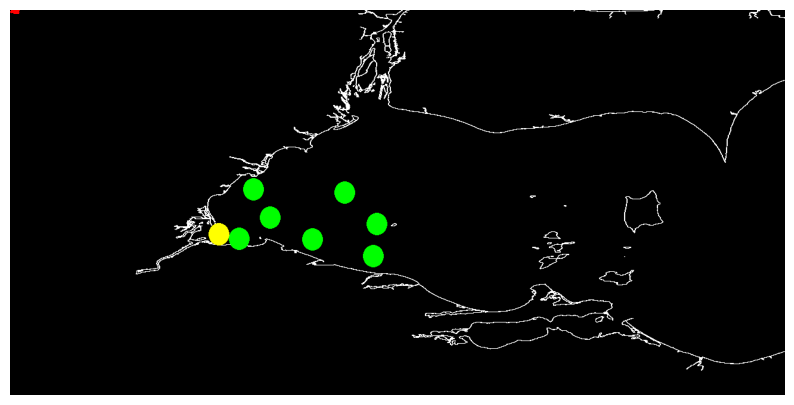

In [ ]:
# ----- Plot Severity Image -----
# reset image
img = np.zeros((ny, nx, 3))
img[land_mask] = [1, 1, 1]   # shoreline white

station_severity_color(
    site_to_coord=site_to_coord,
    station_severity=stat_sev_aug15,
    img_array=img,
    lat_grid=lat_grid,
    lon_grid=lon_grid
)

plt.figure(figsize=(10, 5))
ax = plt.gca()

ax.imshow(img, extent=west_bounds, origin="lower")
western_shoreline.plot(ax=ax, facecolor="none", edgecolor="red")

ax.set_aspect("auto")
ax.axis("off")
plt.show()